In [64]:
from ftag.hdf5 import H5Reader # I use ftag tools to read the file
from ftag import Cuts, Flavour, Flavours
from puma.hlplots import AuxResults, Tagger
from puma.utils.vertexing import calculate_vertex_metrics, build_vertices, clean_reco_vertices, clean_truth_vertices
import numpy as np

# You need to install JAX to be able to run these.
from puma.utils.billoir_vertex_fit import billoir_vertex_fit, billoir_forward
import jax.numpy as jnp


In [ ]:
def Calculate_Lxy(x, y):
    return np.sqrt(x**2 + y**2)

def Calculate_Lxyz(x, y, z):
    return np.sqrt(x**2 + y**2 + z**2)

# Get the vertex indices and track weights! Which tracks belong to which vertex according? The track origin is used for the cleaning
def GetTrackWeights(track_data, incl_vertexing=False, truth=False, max_sv=1):

    if truth:
        raw_vertex_index = track_data["ftagTruthVertexIndex"] # your raw vertex
        track_origin = track_data["ftagTruthOriginLabel"]

    else:
        # Reco Level
        raw_vertex_index = track_data["GN2v01_VertexIndex"] # your raw vertex
        track_origin = track_data["GN2v01_TrackOrigin"]

    # Now clean vertices
    vertex_index  = raw_vertex_index.copy()

    # Prepare mask for filling up
    dummy_track_weights = jnp.zeros((n_jets, max_sv, n_tracks))
    track_weights = jnp.where(dummy_track_weights == 0, np.nan, dummy_track_weights)
    
    for i in range(my_data["tracks"]["GN2v01_VertexIndex"].shape[0]):

        if truth:
            vertex_index[i] = clean_truth_vertices(
            vertex_index[i], track_origin[i], incl_vertexing=incl_vertexing
            )
        
        else:
            vertex_index[i] = clean_reco_vertices(
            vertex_index[i], track_origin[i], incl_vertexing=incl_vertexing
            )

        vertices = build_vertices(vertex_index[i]) # Convert indices to true/false

        for j in range(0, max_sv):
            try:
                track_weights = track_weights.at[i, j].set(vertices[j])
            except:
                continue


    return track_weights, vertex_index


In [3]:
def TransformData(my_data, n_tracks=40):

    # Function to calculate the track parameters in the perigree representation.
    # Returns data x with the format n_jets x n_tracks x n_parameters
    # The n_parameters will first have the variables needed for the billoir fit, some will have to be build by hand because not everything is available

    n_jets, max_tracks = my_data["tracks"].shape

    track = my_data["tracks"][:, 0:n_tracks]
    jet = my_data["jets"][0:n_tracks] # Only needed if you need to calculate the track phi from dphi.

    # Start by getting a mask of the real tracks

    # Get real tracks

    n_real_tracks = jnp.repeat(my_data["jets"]["n_tracks"], n_tracks).reshape(n_jets, n_tracks) # This is needed because jets have a different format than tracks
    track_indices = jnp.tile(
         jnp.arange(0,n_tracks,dtype=jnp.int32),
         n_jets,
    ).reshape(n_jets, n_tracks)

    track_mask = jnp.where(track_indices < n_real_tracks, 1, 0)

    # Compute Input Variables for Billoir Vertex Fit
    ### set parameters for dummy tracks to 1. They will be masked out by the track weight and if you choose a very low value the fit will not work well.

    d0 = jnp.where(track_mask == 0, 1, track["d0"])
    z0 = jnp.where(track_mask == 0, 1, track["z0SinTheta"])

    #jet_phi = jnp.repeat(data["jets"]["phi"], n_tracks).reshape(n_jets, n_tracks) # This is needed because jets have a different format than tracks
    #phi    = jet_phi - track["dphi"] # jet_phi - track_dphi # if track phi is missing you may want to do this instead
    phi = jnp.where(track_mask == 0, 1, track["phi"])

    #print(phi[0], " vs ", track["phi"][0])
    #i, j = 1,1
    #print("Check computation of dphi ", jet_phi[i][j] - track["dphi"][i][j], " = ? = ", phi[i][j])

    theta  = jnp.where(track_mask == 0, 1, track["theta"])
    rho    = jnp.where(track_mask == 0, 1, track["qOverP"]*2*0.2299792*0.001/jnp.sin(track["theta"]))

    d0_error     = jnp.where(track_mask == 0, 1, track["d0Uncertainty"])
    z0_error     = jnp.where(track_mask == 0, 1, track["z0SinThetaUncertainty"])
    phi_error    = jnp.where(track_mask == 0, 1, track["phiUncertainty"])
    theta_error  = jnp.where(track_mask == 0, 1, track["thetaUncertainty"])

    rho_error    = jnp.where(track_mask == 0, 1, track["qOverP"]*2*0.2299792*0.001/jnp.sin(track["theta"]))

    track_origin = jnp.where(track_mask == 0, 1, track["GN2v01_TrackOrigin"])
    track_vertex = jnp.where(track_mask == 0, 1, track["GN2v01_VertexIndex"])
     
    x = jnp.stack([d0, z0, phi, theta, rho, d0_error, z0_error, phi_error, theta_error, rho_error, track_origin, track_vertex, n_real_tracks], axis = 2)

    return x, track


In [4]:
def GetCuts(sample):

    if sample == "ttbar":
        sample_str = "$t\\overline{t}$"
        cuts = [
            ("pt", ">=", 20000),
            ("pt", "<=", 250000),
            ("eta", ">", -2.5),
            ("eta", "<", 2.5),
        ]
        cut_str = "20 < $p_T$ < 250 GeV, $|\\eta| < 2.5$"
            
    elif sample == "zprime":
        sample_str = "Z'"
        cuts = [
            ("pt", ">=", 250000),
            ("pt", "<=", 6000000),
            ("eta", ">", -2.5),
            ("eta", "<", 2.5),
        ]
        cut_str = "250 < $p_T$ < 6000 GeV, $|\\eta| < 2.5$"
    

    return cuts, cut_str



In [5]:
### Read your data!

sample = "ttbar"
mc = "MC23a"
my_dir = "GN2_NDIVE/"

n_jets = 100000
n_tracks = 40 # max 40

## Choose what to read
file_path =  "/fs/ddn/sdf/group/atlas/d/lapereir/GN2/"+my_dir+"/"+mc+"_"+"new-"+sample+".h5"
my_cuts, cut_str = GetCuts(sample)


track_var = ["d0", "z0SinTheta", "dphi", "d0Uncertainty", "z0SinThetaUncertainty", "phiUncertainty", "thetaUncertainty", "qOverPUncertainty", "qOverP", "theta", "eta", "GN2v01_TrackOrigin", "GN2v01_VertexIndex", "ftagTruthOriginLabel", "ftagTruthVertexIndex", "phi"] # for vertex fit
jet_var = ["GN2v00_pb", "GN2v00_pc", "GN2v00_pu", "n_tracks", "jetPtRank", "phi", "HadronConeExclTruthLabelID", "HadronConeExclTruthLabelLxy", "SV1_Lxy", "JetFitterSecondaryVertex_displacement2d", "SV1_L3d", "JetFitterSecondaryVertex_displacement3d", "JetFitter_nVTX", ] # phi is needed for vertex fit if track phi is not available # v00 instead of v01

kinematic_cuts = Cuts.from_list(my_cuts)
print(kinematic_cuts)

## read it!
my_reader = H5Reader(file_path, precision="full", shuffle=False, batch_size=100)
my_data = my_reader.load({"jets": jet_var, "tracks" : track_var}, num_jets=n_jets, cuts=kinematic_cuts)


# now you will be able to read 
# --- data["jets"] with shape n_jets (x n_jet_var tuple)
# --- data["tracks"] with shape n_jets x n_tracks (x n_track_var tuple)
# Note that since jet_var and track_var are stored in a tuple instead of an array when using H5Reader, therefore you will need to convert them to arrays in order to run NDIVE!


['pt >= 20000', 'pt <= 250000', 'eta > -2.5', 'eta < 2.5']


In [6]:
# Process variables required for Vertex fit
# Get variables for tracks with perigree representation
x, track_data = TransformData(my_data, n_tracks = n_tracks)

# Get Vertex Index, where are the secondary vertices?
reco_track_weights, reco_vertex_index = GetTrackWeights(track_data, incl_vertexing=True, truth=False, max_sv=1) # if not inclusive you can choose to store more than one vertex i.e. max_sv != 1


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [7]:
# Do fit
seed = jnp.zeros((n_jets, 3))
vertex_fit, vertex_covariance_fit, vertex_fit_chi2  = billoir_vertex_fit(jnp.array(x[:]), jnp.array(reco_track_weights[:, 0, :]), jnp.array(seed[:])) # the y axis for reco_track_weights indicates which vertex is fitted 0 = leading vertex (only vertex if incl_vertex = True)


Billoir forward tracks
(40, 13)
Traced<ShapedArray(float32[40,13])>with<DynamicJaxprTrace(level=3/1)>
Estimating vertex from weights:
Traced<ShapedArray(float64[40])>with<DynamicJaxprTrace(level=3/1)>


In [97]:
# Save info

Vertex_x = vertex_fit[:, 0]
Vertex_y = vertex_fit[:, 1]
Vertex_z = vertex_fit[:, 2]

Lxy = Calculate_Lxy(Vertex_x,Vertex_y)
Lxyz = Calculate_Lxyz(Vertex_x,Vertex_y, Vertex_z)

print(len(Lxy))


100000


In [56]:
# Now calculate from truth indices (inclusive)
truth_track_weights, truth_vertex_index = GetTrackWeights(track_data, incl_vertexing=True, truth=True, max_sv=1) # if not inclusive you can choose to store more than one vertex
truth_vertex_fit, truth_vertex_covariance_fit, truth_vertex_fit_chi2  = billoir_vertex_fit(jnp.array(x[:]), jnp.array(truth_track_weights[:, 0, :]), jnp.array(seed[:])) # the y axis for reco_track_weights indicates which vertex is fitted 0 = leading vertex
Lxy_truth = Calculate_Lxy(truth_vertex_fit[:, 0],truth_vertex_fit[:, 1])


In [105]:
# Now same thing but using reco and non-inclusive vertices i.e. there may be tertiary vetices!
# Now calculate from truth indices
non_incl_reco_track_weights, non_incl_reco_vertex_index = GetTrackWeights(track_data, incl_vertexing=False, truth=False, max_sv=3) # if not inclusive you can choose to store more than one vertex
non_incl_reco_vertex_fit, non_incl_reco_vertex_covariance_fit, non_incl_reco_vertex_fit_chi2  = billoir_vertex_fit(jnp.array(x[:]), jnp.array(non_incl_reco_track_weights[:, 0, :]), jnp.array(seed[:])) # the y axis for reco_track_weights indicates which vertex is fitted 0 = leading vertex
Lxy_non_incl_reco = Calculate_Lxy(non_incl_reco_vertex_fit[:, 0],non_incl_reco_vertex_fit[:, 1])
Lxyz_non_incl_reco = Calculate_Lxyz(non_incl_reco_vertex_fit[:, 0],non_incl_reco_vertex_fit[:, 1], non_incl_reco_vertex_fit[:, 2])

In [98]:
Lxyz_truth = Calculate_Lxyz(truth_vertex_fit[:, 0],truth_vertex_fit[:, 1], truth_vertex_fit[:, 2])


In [29]:
# How many non nans do we have for each tagger?

print(len(Lxy[np.invert(np.isnan(Lxy))]))
print(len(my_data["jets"]["SV1_Lxy"][np.invert(np.isnan(my_data["jets"]["SV1_Lxy"]))]))

print(len(Lxy[(np.isnan(Lxy))]))
print(len(my_data["jets"]["SV1_Lxy"][(np.isnan(my_data["jets"]["SV1_Lxy"]))]))

print(np.max(Lxy[np.invert(np.isnan(Lxy))]))
print(np.max(my_data["jets"]["SV1_Lxy"][np.invert(np.isnan(my_data["jets"]["SV1_Lxy"]))]))

print(np.min(Lxy[np.invert(np.isnan(Lxy))]))
print(np.min(my_data["jets"]["SV1_Lxy"][np.invert(np.isnan(my_data["jets"]["SV1_Lxy"]))]))


#np.where(Lxy == (np.max(Lxy)))


39993
36030
60007
63970
1364.161453383385
172.31421
0.0010135192773401734
0.01403605


(array([], dtype=int64),)

In [93]:
for i in range(0, 20):
    print(vertex_fit[jet_flavour(jets, "b")][i])

[nan nan nan]
[ 6.20781482 -4.47571883 31.06230467]
[nan nan nan]
[ 2.66909473  1.72924903 -8.77951653]
[ 0.74097025 -0.44042713  2.55685641]
[-16.41560296  -2.55846766  14.65148898]
[nan nan nan]
[-0.25863488  0.3781515  -0.22244881]
[3.78642669 1.36249963 2.88112875]
[ 0.19367408 -0.54565672 -0.64029756]
[-0.98858299  3.83695145 -5.84550451]
[ 3.47801291 -4.91396044 -2.45243633]
[-0.01338307  0.01933925 -0.077167  ]
[ 4.85573855  0.18254631 -0.7148914 ]
[ 2.73917568  4.45638979 -0.84825407]
[ 2.2122958   0.70014839 -2.18649371]
[nan nan nan]
[-9.7151646  -4.80589772 -4.31383794]
[nan nan nan]
[ 0.17610097 -0.39741132 -0.11071051]


1364.161453383385
172.31421


/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid value encountered in subtract
  y1=np.nan_to_num(ratio - ratio_unc, nan=0, posinf=0),
/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid value encountered in subtract
  y1=np.nan_to_num(ratio - ratio_unc, nan=0, posinf=0),
/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid value encountered in subtract
  y1=np.nan_to_num(ratio - ratio_unc, nan=0, posinf=0),
/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid value encountered in subtract
  y1=np.nan_to_num(ratio - ratio_unc, nan=0, posinf=0),


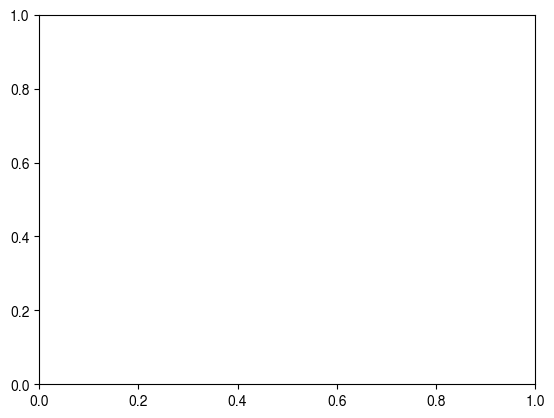

In [104]:
# Plot basic histogram1

def leading_jet(jet):
    return jet["jetPtRank"] == 0
    
def jet_flavour(jet, f=""):
    if f == "b": return jet["HadronConeExclTruthLabelID"] == 5
    elif f == "c": return jet["HadronConeExclTruthLabelID"] == 4
    elif f == "light": return jet["HadronConeExclTruthLabelID"] == 0
    else:  return jet ["HadronConeExclTruthLabelID"] >= 0
            

print(np.max(Lxy[np.invert(np.isnan(Lxy))]))
print(np.max(my_data["jets"]["SV1_Lxy"][np.invert(np.isnan(my_data["jets"]["SV1_Lxy"]))]))

np.where(Lxy == (np.max(Lxy)))

from puma import Histogram, HistogramPlot

jets = my_data["jets"]

leading_jets = jets[leading_jet(jets)]
jet1_Lxy = Lxy[leading_jet(jets)]
jet1_Lxy_truth = Lxy_truth[leading_jet(jets)]

for flavour in ["all", "light", "bjets", "cjets"]:

    # Choose selection
    if flavour == "all":
        f = ""
        flav_str = "(all flavours)"
    
    if flavour == "bjets":
        f = "b"
        flav_str = "(b-jets)"
    
    if flavour == "cjets":
        f = "c"
        flav_str = "(c-jets)"
    
    if flavour == "light":
        f = "light"
        flav_str = "(light jets)"
    
    
    #expectation_hist = Histogram(vertex_metrics["n_match"][is_flavour], label="n match", histtype="stepfilled", alpha=1)
    
    # the variable needs to be an array
    
    truth_hist = Histogram(jets["HadronConeExclTruthLabelLxy"][jet_flavour(jets, f)], label="Truth", histtype="step", alpha=1)
    gn2_hist = Histogram(Lxy[jet_flavour(jets, f)], label="GN2 (reco)", histtype="step", alpha=1)
    gn2_truth_hist = Histogram(Lxy_truth[jet_flavour(jets, f)], label="GN2 (truth)", histtype="step", alpha=1)
    sv1_hist = Histogram(jets["SV1_Lxy"][jet_flavour(jets, f)], label="SV1", histtype="step", alpha=1)
    JetFitter_hist = Histogram(jets["JetFitterSecondaryVertex_displacement2d"][jet_flavour(jets, f)], label="JetFitter", histtype="step", alpha=1)
    
    
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel="Normalized events",
        xlabel="Lxy",
        logy=True,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=40,  # you can also define an integer number for the number of bins
        bins_range=(0,40),  # only considered if bins is an integer
        norm=True,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag=mc+" "+sample+" "+flav_str,
        figsize=(6, 5),
        n_ratio_panels=1,
    )
    
    plot_histo.add(truth_hist, reference=True)
    plot_histo.add(gn2_hist, reference=False)
    plot_histo.add(gn2_truth_hist, reference=False)
    plot_histo.add(sv1_hist, reference=False)
    #plot_histo.add(JetFitter_hist, reference=False)
    
    
    plot_histo.draw()
    
    plot_histo.savefig("Histogram_Lxy_long_"+flavour+"_normalized.png", transparent=False)


In [ ]:
jets = my_data["jets"]

leading_jets = jets[leading_jet(jets)]
jet1_Lxy = Lxy[leading_jet(jets)]
jet1_Lxy_truth = Lxy_truth[leading_jet(jets)]

for flavour in ["all", "light", "bjets", "cjets"]:

    # Choose selection
    if flavour == "all":
        f = ""
        flav_str = "(all flavours)"
    
    if flavour == "bjets":
        f = "b"
        flav_str = "(b-jets)"
    
    if flavour == "cjets":
        f = "c"
        flav_str = "(c-jets)"
    
    if flavour == "light":
        f = "light"
        flav_str = "(light jets)"
    
    
    #expectation_hist = Histogram(vertex_metrics["n_match"][is_flavour], label="n match", histtype="stepfilled", alpha=1)
    
    # the variable needs to be an array
    
    truth_hist = Histogram(jets["HadronConeExclTruthLabelLxy"][jet_flavour(jets, f)], label="Truth", histtype="step", alpha=1)
    gn2_hist = Histogram(Lxy[jet_flavour(jets, f)], label="GN2 (reco)", histtype="step", alpha=1)
    gn2_truth_hist = Histogram(Lxy_truth[jet_flavour(jets, f)], label="GN2 (truth)", histtype="step", alpha=1)
    sv1_hist = Histogram(jets["SV1_Lxy"][jet_flavour(jets, f)], label="SV1", histtype="step", alpha=1)
    JetFitter_hist = Histogram(jets["JetFitterSecondaryVertex_displacement2d"][jet_flavour(jets, f)], label="JetFitter", histtype="step", alpha=1)
    
    
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel="Normalized events",
        xlabel="Lxy",
        logy=True,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=40,  # you can also define an integer number for the number of bins
        bins_range=(0,40),  # only considered if bins is an integer
        norm=True,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag=mc+" "+sample+" "+flav_str,
        figsize=(6, 5),
        n_ratio_panels=1,
    )
    
    plot_histo.add(truth_hist, reference=True)
    plot_histo.add(gn2_hist, reference=False)
    plot_histo.add(gn2_truth_hist, reference=False)
    plot_histo.add(sv1_hist, reference=False)
    #plot_histo.add(JetFitter_hist, reference=False)
    
    
    plot_histo.draw()
    
    plot_histo.savefig("Histogram_Lxy_long_"+flavour+"_normalized.png", transparent=False)


In [ ]:
jets = my_data["jets"]

for flavour in ["all", "light", "bjets", "cjets"]:

    # Choose selection
    if flavour == "all":
        f = ""
        flav_str = "(all flavours)"
    
    if flavour == "bjets":
        f = "b"
        flav_str = "(b-jets)"
    
    if flavour == "cjets":
        f = "c"
        flav_str = "(c-jets)"
    
    if flavour == "light":
        f = "light"
        flav_str = "(light jets)"
    
    
    #expectation_hist = Histogram(vertex_metrics["n_match"][is_flavour], label="n match", histtype="stepfilled", alpha=1)
    
    # the variable needs to be an array
    
    truth_hist = Histogram(jets["HadronConeExclTruthLabelLxy"][jet_flavour(jets, f)], label="Truth", histtype="step", alpha=1)
    gn2_hist = Histogram(Lxyz[jet_flavour(jets, f)], label="GN2 (reco)", histtype="step", alpha=1)
    gn2_truth_hist = Histogram(Lxyz_truth[jet_flavour(jets, f)], label="GN2 (truth)", histtype="step", alpha=1)
    sv1_hist = Histogram(jets["SV1_3d"][jet_flavour(jets, f)], label="SV1", histtype="step", alpha=1)
    JetFitter_hist = Histogram(jets["JetFitterSecondaryVertex_displacement2d"][jet_flavour(jets, f)], label="JetFitter", histtype="step", alpha=1)
    
    
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel="Number of events",
        xlabel="Leading jet Lxy",
        logy=True,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=20,  # you can also define an integer number for the number of bins
        bins_range=(0,20),  # only considered if bins is an integer
        norm=False,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag=mc+" "+sample+" "+flav_str,
        figsize=(6, 5),
        n_ratio_panels=1,
    )
    
    plot_histo.add(truth_hist, reference=True)
    plot_histo.add(gn2_hist, reference=False)
    plot_histo.add(gn2_truth_hist, reference=False)
    plot_histo.add(sv1_hist, reference=False)
    #plot_histo.add(JetFitter_hist, reference=False)
    
    
    plot_histo.draw()
    
    plot_histo.savefig("Histogram_Lxyz_"+flavour+".png", transparent=False)


In [62]:
# Other metrics from Johanne's
#     Dictionary containing the following metrics:
#         n_match: np.ndarray
#             Array of shape (n_jets) containing the number of matched vertices per
#             jet.
#         n_test: np.ndarray
#             Array of shape (n_jets) containing the number of reco vetices per jet.
#         n_ref: np.ndarray
#             Array of shape (n_jets) containing the number of truth vertices per jet.
#         track_overlap: np.ndarray
#             Array of shape (n_jets, max_vertices) containing the number of
#             overlapping tracks between each matched vertex pair.
#         test_vertex_size: np.ndarray
#             Array of shape (n_jets, max_vertices) containing the number of tracks
#             in each matched reco vertex.
#         ref_vertex_size: np.ndarray
#             Array of shape (n_jets, max_vertices) containing the number of tracks
#             in each matched truth vertex.


vertex_metrics = calculate_vertex_metrics(reco_vertex_index, truth_vertex_index)

n_reco_vertex = vertex_metrics["n_test"] # 1D (jet)
n_truth_vertex = vertex_metrics["n_ref"] # 1D (jet)

n_reco_tracks_per_vertex = vertex_metrics["test_vertex_size"] # 2D (jet, vertex)
n_truth_tracks_per_vertex = vertex_metrics["ref_vertex_size"]  # 2D (jet, vertex)

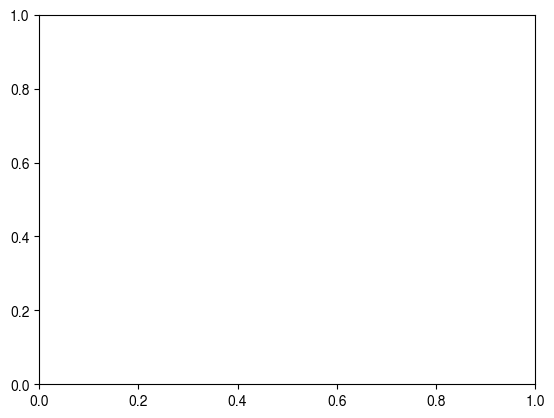

In [81]:
var = np.array(vertex_fit[:, 2])
var_name = "vertex_z_reco"

    
#expectation_hist = Histogram(vertex_metrics["n_match"][is_flavour], label="n match", histtype="stepfilled", alpha=1)

# the variable needs to be an array

b_hist = Histogram(var[jet_flavour(jets, "b")], label="b-jets", histtype="step", alpha=1)
c_hist = Histogram(var[jet_flavour(jets, "c")], label="c-jets", histtype="step", alpha=1)
l_hist = Histogram(var[jet_flavour(jets, "light")], label="light", histtype="step", alpha=1)
#sv1_hist = Histogram(jets["SV1_Lxy"][jet_flavour(jets, f)], label="SV1", histtype="step", alpha=1)
#JetFitter_hist = Histogram(jets["JetFitterSecondaryVertex_displacement2d"][jet_flavour(jets, f)], label="JetFitter", histtype="step", alpha=1)


# Initialise histogram plot
plot_histo = HistogramPlot(
    ylabel="Number of events",
    xlabel="SV z",
    logy=True,
    # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
    bins=40,  # you can also define an integer number for the number of bins
    bins_range=(-30,50),  # only considered if bins is an integer
    norm=False,
    atlas_first_tag="Simulation Internal",
    atlas_second_tag=mc+" "+sample+" ",
    figsize=(6, 3),
    n_ratio_panels=0,
)

#plot_histo.add(truth_hist, reference=True)
plot_histo.add(b_hist, reference=True)
plot_histo.add(c_hist, reference=False)
plot_histo.add(l_hist, reference=False)

#plot_histo.add(sv1_hist, reference=False)
#plot_histo.add(JetFitter_hist, reference=False)


plot_histo.draw()

plot_histo.savefig("Histogram_"+var_name+".png", transparent=False)

In [ ]:
var = n_reco_vertex
var_name = "num_SV_reco"

    
#expectation_hist = Histogram(vertex_metrics["n_match"][is_flavour], label="n match", histtype="stepfilled", alpha=1)

# the variable needs to be an array

b_hist = Histogram(var[jet_flavour(jets, "b")], label="b-jets", histtype="step", alpha=1)
c_hist = Histogram(var[jet_flavour(jets, "c")], label="c-jets", histtype="step", alpha=1)
l_hist = Histogram(var[jet_flavour(jets, "light")], label="light", histtype="step", alpha=1)
#sv1_hist = Histogram(jets["SV1_Lxy"][jet_flavour(jets, f)], label="SV1", histtype="step", alpha=1)
#JetFitter_hist = Histogram(jets["JetFitterSecondaryVertex_displacement2d"][jet_flavour(jets, f)], label="JetFitter", histtype="step", alpha=1)


# Initialise histogram plot
plot_histo = HistogramPlot(
    ylabel="Number of events",
    xlabel="# SV",
    logy=True,
    # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
    bins=5,  # you can also define an integer number for the number of bins
    bins_range=(0,3),  # only considered if bins is an integer
    norm=False,
    atlas_first_tag="Simulation Internal",
    atlas_second_tag=mc+" "+sample+" "+flav_str,
    figsize=(6, 3),
    n_ratio_panels=0,
)

#plot_histo.add(truth_hist, reference=True)
plot_histo.add(b_hist, reference=True)
plot_histo.add(c_hist, reference=False)
plot_histo.add(l_hist, reference=False)

#plot_histo.add(sv1_hist, reference=False)
#plot_histo.add(JetFitter_hist, reference=False)


plot_histo.draw()

plot_histo.savefig("Histogram_"+var_name+".png", transparent=False)

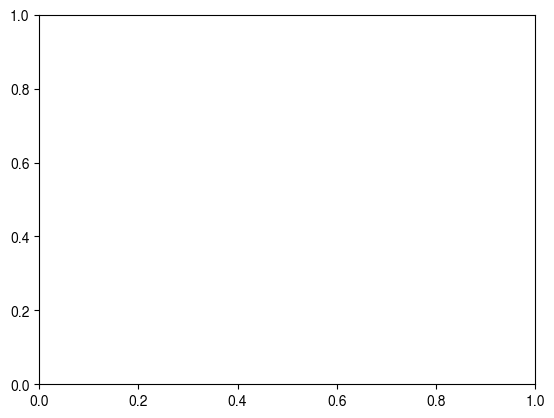

In [8]:
# Alternative method
# Load tagger instead of opening files with the reader

# Vertexing straight from Tagger (Johanne's style). You can run this cell to produce the vertex plots done by Johanne's for the paper but using your samples. You can then use these to compare to your individual plots as validation of the SV finding part.

GN2 = Tagger(
        name="GN2v01",
        label="GN2v01",
        colour="deepskyblue",
        reference=True,
        aux_tasks=["vertexing", "track_origin"]
)

JetFitter = Tagger(
    name="JF",
    label="JetFitter",
    colour="green",
    reference=False,
    aux_tasks=["vertexing"],
)

SV1 = Tagger(
    name="SV1",
    label="SV1",
    colour="pink",
    reference=False,
    aux_tasks=["vertexing"],
)

aux_results = AuxResults(
      sample=sample + "_" + mc, perf_vars=["pt"], remove_nan=True
)

# load tagger from the file object

taggers = [GN2] #SV1, GN2, JetFitter]

aux_results.load_taggers_from_file(
    taggers,
    sample_path,
    cuts=cuts,
    num_jets=n_jets,
)

aux_results.atlas_first_tag = "Simulation Internal"

com = "13" if "MC20" in mc else "13.6"
aux_results.atlas_second_tag = (
    "$\\sqrt{s}=" + com + "$ TeV, " + mc + "\n" + sample_str + ", " + cut_str
)

# Make a plot

aux_results.plot_var_vtx_perf(
    vtx_flavours=["bjets"],
    no_vtx_flavours=["ujets"],
    xlabel=r"$p_{T}$ [GeV]",
    perf_var="pt",
    incl_vertexing=True,
)
